In [11]:
from my_metrics import *
from sub_network import *
from data_loader import *
from plotting_utils import *

from sklearn.metrics import roc_curve, confusion_matrix

import matplotlib.pyplot as plt

In [12]:
image_dir1 = r"D:\ib811_database\S1_IEEE"
image_dir2 = r"D:\ib811_database\S2_IEEE"

images1 = load_images(image_dir1)
images2 = load_images(image_dir2)

pairs_1, pairs_2, labels = create_labels(images1, images2)


In [13]:
inputShape = (256, 256, 1)

inputA = Input(inputShape)
inputB = Input(inputShape)

featureExtractor = sub_network(inputShape)

featsA = featureExtractor(inputA)
featsB = featureExtractor(inputB)

distance = EuclideanDistance()([featsA, featsB])

outputs = Dense(1, activation="sigmoid")(distance)

model = Model(inputs=[inputA, inputB], outputs=outputs)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_6 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1849

test_pairs_1.shape=(640, 256, 256)
test_pairs_2.shape=(640, 256, 256)
test_labels.shape=(640,)
20/20 [==============================] - 1s 33ms/step


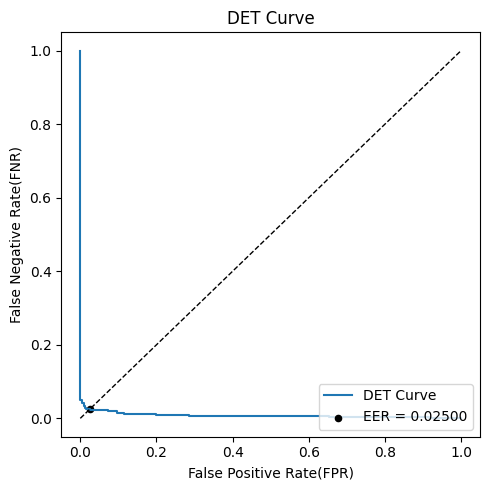

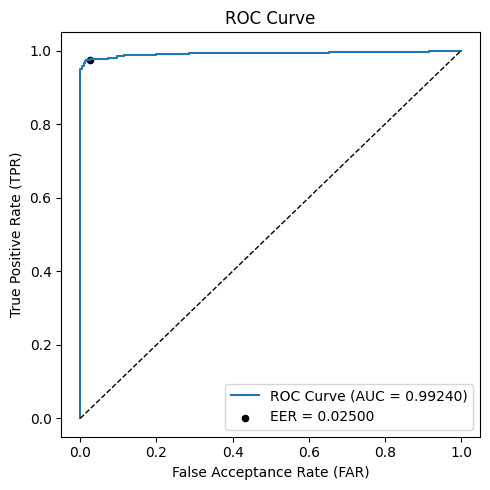

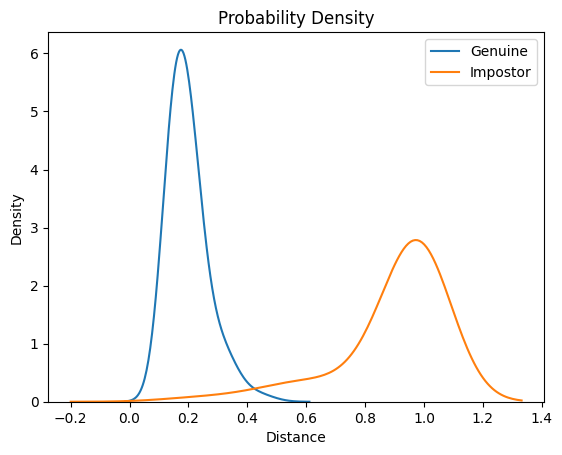

In [14]:
test_pairs_1, test_pairs_2, test_labels = pairs_1, pairs_2, labels

print("test_pairs_1.shape={}".format(test_pairs_1.shape))
print("test_pairs_2.shape={}".format(test_pairs_2.shape))
print("test_labels.shape={}".format(test_labels.shape))

testPairs_0 = np.array(test_pairs_1).reshape(-1, 256, 256, 1)
testPairs_1 = np.array(test_pairs_2).reshape(-1, 256, 256, 1)

model.load_weights("snn.hdf5")

y_pred = model.predict([testPairs_0, testPairs_1]).ravel()

fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
eer, eer_threshold = compute_eer(fpr, tpr, thresholds)

EER = eer

with open("det_eer_data.txt", "w") as f:
    f.write(f"EER: {EER}\n")
    f.write(f"Threshold at EER: {eer_threshold}\n")

with open("det_curve_data.txt", "w") as f:
    f.write("False Positive Rate(%), False Negative Rate(%), Thresholds\n")
    for i in range(len(fpr)):
        f.write(f"{fpr[i]}, {1 - tpr[i]}, {thresholds[i]}\n")

plot_det_curve(fpr, 1 - tpr, EER, label="DET Curve")

with open("roc_curve_data.txt", "w") as f:
    f.write("False Acceptance Rate (FAR), True Positive Rate (TPR), Thresholds\n")
    for i in range(len(fpr)):
        f.write(f"{fpr[i]}, {tpr[i]}, {thresholds[i]}\n")
        
    f.write(f"\nEER: {EER}\n")
    f.write(f"Threshold at EER: {eer_threshold}\n")

plot_roc_curve(fpr, tpr, EER)

genuine_scores = y_pred[test_labels == 0]
impostor_scores = y_pred[test_labels == 1]

with open("scores_distribution.txt", "w") as f:
    f.write("Score Type,Score\n")
    for score in genuine_scores:
        f.write(f"Genuine,{score}\n")
    for score in impostor_scores:
        f.write(f"Impostor,{score}\n")

plot_density(genuine_scores, impostor_scores)

混淆矩陣:
 [[312   8]
 [  8 312]]

True Negatives: 312
False Positives: 8
False Negatives: 8
True Positives: 312


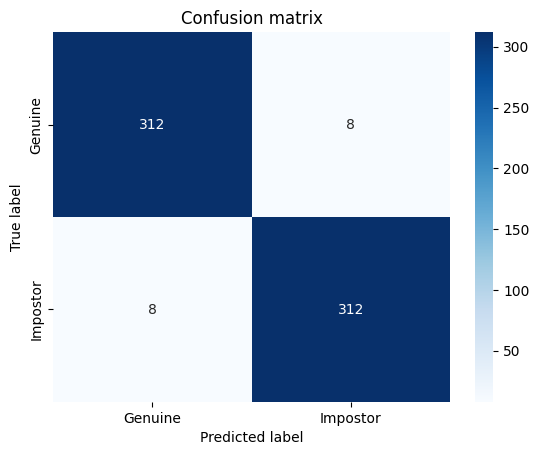

In [15]:
y_pred_binary = (y_pred >= eer_threshold).astype(int)

conf_matrix = confusion_matrix(test_labels, y_pred_binary)
print("混淆矩陣:\n", conf_matrix)

tn, fp, fn, tp = conf_matrix.ravel()
print(f"\nTrue Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

class_names = ["Genuine", "Impostor"]

plot_confusion_matrix(conf_matrix, class_names)